In [1]:
%load_ext autoreload
%autoreload 2

import sys
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils import data
from torch.optim import Adam

from torchvision import transforms
from torchvision import datasets

import numpy as np

from matplotlib import pyplot as plt
from pandas import read_fwf, DataFrame
from tqdm   import tqdm_notebook as tqdm
import matplotlib.gridspec as gridspec


from skimage import exposure
from skimage import measure
from skimage.io import imsave
from skimage.filters import gaussian as gaussian_filter
from skimage.filters import threshold_otsu
from skimage import filters
from skimage.morphology import opening, closing, disk, binary_dilation, flood

In [2]:
sys.path.append('../')
from VAE.rg_dataset import LRG, BasicDataset
from VAE.vae_models import VAE
from VAE.loss_funcs import *

In [3]:
data_path = '../data/'
n_aug = 15

In [4]:
%%time
lrg_data_set   = LRG(use_kittler=True, n_aug=n_aug, blur=False, catalog_dir=data_path + 'catalog/mrt-table3.txt', 
                                                  twice=False, file_dir=data_path + 'lrg')

unlrg_data_set = LRG(use_kittler=True, n_aug=n_aug, blur=False, catalog_dir=data_path + 'catalog/mrt-table4.txt',
                                                  twice=True, file_dir=data_path + 'unlrg')

../data/lrg:	1442/1442
../data/unlrg:	14245/14245
CPU times: user 6min 2s, sys: 6min 32s, total: 12min 35s
Wall time: 4min 12s


In [5]:
batch_size = 128

In [27]:
data_loader_lrg   = data.DataLoader(lrg_data_set,   batch_size=batch_size, shuffle=False)
data_loader_unlrg = data.DataLoader(unlrg_data_set, batch_size=batch_size, shuffle=True)

sample = iter(data_loader_lrg).next()
sampleunlrg = iter(data_loader_unlrg).next()

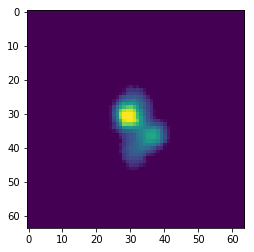

In [7]:
plt.imshow(sample[0][0][0])

In [19]:
device = 'cuda'

lr=0.001
n_epochs = 50

gam = 1
cap = 10
decay  = 0.015
lt_dim = 8

k=[1, 64, 128, 128, 256, 256] # number of filters

In [20]:
beta_vae_loss = B_VAE_Loss_cap(gamma=gam, max_capacity=cap, epochs=n_epochs)

In [21]:
vae = VAE(lt_dim, k).to(device)

In [50]:
v1, v2 = vae.encode(sampleunlrg[0].to(device)), vae.encode(sampleunlrg[1].to(device))

# (v2[0] + v1[0]) / 2

v3 = (v2[0] + v1[0]) / 2
v3[:, -1] = v1[0][:,-1]
# v3
v2[0]

tensor([[ 0.5147, -0.3727,  0.1991,  ..., -0.0980,  0.2960, -0.2858],
        [-0.6257, -0.2372, -0.4030,  ...,  0.2359,  0.3194,  1.2403],
        [ 0.5602,  0.0314,  0.3393,  ...,  0.1242,  0.2107, -0.0816],
        ...,
        [-0.0123, -0.2939, -0.9430,  ..., -0.0877, -0.6125,  0.2424],
        [-0.0126,  0.0346,  0.1227,  ...,  0.8152, -0.4348,  0.6037],
        [ 1.4222, -0.2740,  0.9530,  ..., -0.1794,  0.0633, -0.5443]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [51]:
optimizer = Adam(vae.parameters(), lr=lr, weight_decay=1E-5)

In [52]:
def train_step_b_vae_cap(model, device, data_loader, optim, epoch, loss_fun, log_interval=5):
    model.train()
    s = ''
    r_loss = 0
    batch_sum = 0 
    for batch_idx, (data, data1, target) in enumerate(data_loader):
        batch_sum += len(data)
        data  = data.to(device)
        data1 = data1.to(device)
        
        target = Variable(target, requires_grad=False).to(device)
        #Forward Pass
        optim.zero_grad()
        output1_m, output1_v = model.encode(data)
        output2_m, output2_v = model.encode(data1)
        
        mu  = (output1_m + output2_m) / 2
        var = (output1_m + output2_m) / 2
        
        mu[:, -1]  = output1_m[:, -1]
        var[:, -1] = output1_v[:, -1]
        
        output = model.decode(model.reparameterize(mu, var)), mu, var
        #############################################
        ######### check against known class #########
        #############################################
        #########    Compact vs Extended    #########
        # ext_loss = compact_extended_loss(target, output[1][:,0], device)
        # # #########       FRI vs FRII         #########
        # fr_loss = fri_frii_loss(target, output[1][:, 1], device)
        # #########   Try to learn rotation   #########
        
        # Non Rotated part loss
        v1, v2 = output1_m[:,:-1], output2_m[:,:-1]
        rot_loss = F.mse_loss(v1, v2)
        # BCE Loss
        c, r_loss , g_loss = loss_fun(output, data)
        loss = 30*r_loss + g_loss + rot_loss #+ 20 * (ext_loss + fr_loss)#
        #Backpropagation
        loss.backward()
        optim.step()
        s = 'Train Epoch: {:3d} [{:5d}/{:5d} ({:3.0f}%)]   Loss: {:4.4f}   Rot_Loss: {:4.4f}   Capacity: {:4.2f}'
        s = s.format(epoch, batch_sum, len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.item(), rot_loss.item(), c)
        if batch_idx % log_interval == 0:
            sys.stdout.write('{}\r'.format(s))
            sys.stdout.flush()
    return s, r_loss.item()

In [53]:
def test_step_b_vae_cap(model, device, data_loader, loss_fun):
    model.train()
    r_loss = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        with torch.no_grad():
            data = data.to(device)
            #Forward Pass
            output = model(data)
            # BCE Loss
            c, r_loss , g_loss = loss_fun(output, data)
    return r_loss.item()

In [ ]:
train_loss = []
test_loss  = []
for epoch in range(1, n_epochs+1):
    #LRG, forced params
    start = time.time()
    s, l = train_step_b_vae_cap(vae, device, data_loader_unlrg, optimizer, epoch, loss_fun=beta_vae_loss)
    loss = test_step_b_vae_cap(vae, device, data_loader_lrg, loss_fun=beta_vae_loss)
    train_loss.append(l)
    test_loss.append(loss)
    t = time.time() - start
    sys.stdout.write('{}   Test Loss : {:4.4f}   Time : {:.2f}s\n'.format(s, loss, t))
    beta_vae_loss.update()

Train Epoch:   1 [209700/209700 (100%)]   Loss: 2723.6257   Rot_Loss: 2.4319   Capacity: 1.20   Test Loss : 260.2049   Time : 243.43s
Train Epoch:   2 [209700/209700 (100%)]   Loss: 1984.8414   Rot_Loss: 2.3122   Capacity: 1.40   Test Loss : 271.4962   Time : 240.31s
Train Epoch:   3 [209700/209700 (100%)]   Loss: 2132.4846   Rot_Loss: 1.3718   Capacity: 1.60   Test Loss : 267.0035   Time : 241.98s
Train Epoch:   4 [209700/209700 (100%)]   Loss: 2398.1597   Rot_Loss: 1.3339   Capacity: 1.80   Test Loss : 264.5574   Time : 241.27s
Train Epoch:   5 [209700/209700 (100%)]   Loss: 1819.6912   Rot_Loss: 1.0383   Capacity: 2.00   Test Loss : 272.7168   Time : 240.24s
Train Epoch:   6 [209700/209700 (100%)]   Loss: 2232.4185   Rot_Loss: 1.3750   Capacity: 2.20   Test Loss : 272.0349   Time : 239.61s
Train Epoch:   7 [209700/209700 (100%)]   Loss: 1936.7063   Rot_Loss: 0.9336   Capacity: 2.40   Test Loss : 259.9514   Time : 240.40s
Train Epoch:   8 [209700/209700 (100%)]   Loss: 2238.2668   Ro

In [ ]:
a = 1#6
s, l = sample[0][a:a+1], sample[1][a:a+1]
with torch.no_grad():
    e = vae.encode(s.to(device))[0]
    d = vae.decode(e)
f, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(s[0][0])
ax[1].imshow(d.cpu()[0][0])
ax[2].imshow(s[0][0] - d.cpu()[0][0], cmap='gray')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')